In [1]:
%%capture
%run ch04_linear_algebra.ipynb
%run ch10_working_with_data.ipynb
# %run ch19_deep_learning.ipynb

In [2]:
# Word Clouds

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

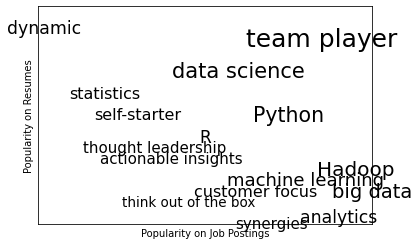

In [3]:
from matplotlib import pyplot as plt

def text_size(total: int) -> float:
    """Equals 8 if total is 0, 28 if total is 200"""
    
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word, 
             ha='center', va='center', 
             size=text_size(job_popularity + resume_popularity))
    
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
# n-Gram language Model - bigram

def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'") # handle Unicode apostrophes

In [5]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/radar/what-is-data-science/"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "main-post-radar-content")      # find main-post-radar-content div
regex = r"[\w']+|[\.]"                                     # matches a word or a period

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text)) # find words in each paragraph (parsing)
    document.extend(words)

In [6]:
from collections import defaultdict

transitions = defaultdict(list)

for previous, current in zip(document, document[1:]):
    transitions[previous].append(current)

In [7]:
import random

def generate_using_bigrams() -> str:
    current = "." # this means the next word will start a sentence
    result = []
    
    while True:
        next_word_candidates = transitions[current]      # all the words following the current word
        current = random.choice(next_word_candidates)    # choose one candidate word at random
        result.append(current)
        
        if current == ".":
            return " ".join(result)                      # if we see ".", we're done generating sentence

In [8]:
generate_using_bigrams()

'They group recommendation engines and data scientists started small .'

In [9]:
# n-Gram language Model - trigram

trigram_transitions = defaultdict(list)
starts = []

for previous, current, next in zip(document, document[1:], document[2:]):
    
    if previous == ".":               # if the previous word was a period
        starts.append(current)        # then the current word is a start word
        
    trigram_transitions[(previous, current)].append(next)

In [10]:
def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random start word
    previous = "."                    # and precede it with a '.'
    result = [current]
    
    while True:
        next_word_canidates = trigram_transitions[(previous, current)]
        next_word = random.choice(next_word_canidates)
        
        previous, current = current, next_word   # move forward by 1 word
        result.append(current)
        
        if current == ".":
            return " ".join(result)

In [11]:
generate_using_trigrams()

'If you have a strong mathematical background computing skills and come from a discipline in which survival depends on getting the most messy and their schemas evolve as the understanding of the earlier data products incrementally the ability to take data â but â bigâ is really to investigate the data lifecycle where it comes close to providing â one stop information platform Hadoop is it .'

In [12]:
# Grammars

from typing import List, Dict

Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

In [13]:
def is_terminal(token: str) -> bool:
    return token[0] != "_" # not grammar

In [14]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    
    for i, token in enumerate(tokens):
        
        # If this is a terminal taken, skip it
        if is_terminal(token): continue
            
        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random
        replacement = random.choice(grammar[token])
        
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be, e.g., "_NP _VP", so we need to
            # split it on spaces and splice it in
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        
        # Now call expand on the new list of tokens (recursive call)
        return expand(grammar, tokens)
    
    # If we get here, we had all terminals and are done
    return tokens

In [15]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

In [16]:
print(*generate_sentence(grammar))

Python tests big data science about logistic data science


In [17]:
# Gibbs Sampling

from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    
    return d1, d1 + d2

In [18]:
def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ..., x + 6"""
    
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [19]:
for _ in range(10):
    x_tmp = random_x_given_y(11)
    y_tmp = random_y_given_x(x_tmp) 
    
    print(x_tmp, y_tmp - x_tmp)

5 4
6 2
5 5
6 5
6 3
5 2
5 3
6 3
5 5
5 1


In [20]:
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    
    return x, y # a sample from the unconditional joint distribution

In [21]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
        
    return counts

In [22]:
compare_distributions()

defaultdict(<function __main__.compare_distributions.<locals>.<lambda>()>,
            {(1, 4): [35, 28],
             (4, 9): [29, 34],
             (6, 10): [32, 24],
             (2, 3): [29, 23],
             (2, 6): [33, 27],
             (3, 9): [21, 24],
             (1, 5): [31, 26],
             (4, 10): [18, 30],
             (3, 5): [35, 31],
             (3, 6): [34, 20],
             (6, 7): [28, 25],
             (1, 3): [20, 23],
             (3, 7): [30, 32],
             (6, 11): [28, 29],
             (4, 6): [18, 29],
             (2, 5): [23, 24],
             (4, 5): [31, 29],
             (6, 12): [26, 26],
             (5, 10): [33, 35],
             (4, 7): [20, 14],
             (3, 8): [28, 25],
             (1, 6): [33, 31],
             (1, 7): [37, 25],
             (5, 11): [24, 30],
             (6, 8): [22, 32],
             (6, 9): [26, 39],
             (2, 8): [23, 20],
             (4, 8): [25, 24],
             (5, 9): [35, 34],
             (5, 7):

In [23]:
# Topic Modeling (Latent Dirichlet Allocation)

def sample_from(weights: List[float]) -> int:
    """Returns i with probability weights[i] / sum(weights)"""
    
    total = sum(weights)
    rnd = total * random.random()     # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                      # return the smallest i such that
        if rnd <= 0: return i         # weights[0] + ... + weights[i] >= rnd

In [24]:
from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))

assert 10 < draws[0] < 190   # 10%
assert 10 < draws[1] < 190   # 10%
assert 650 < draws[2] < 950  # 80%
assert draws[0] + draws[1] + draws[2] == 1000

In [25]:
# Data

documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [26]:
K = 4   # 4 topics

document_topic_counts = [Counter() for _ in documents]       # how many times each topic is assigned to each document
topic_word_counts = [Counter() for _ in range(K)]            # how many times each word is assigned to each topic
topic_counts = [0 for _ in range(K)]                         # total number of words assigned to each topic
document_lengths = [len(document) for document in documents] # total number of words contained in each document
distinct_words = set(word                                    # distinct words 
                     for document in documents 
                     for word in document)
W = len(distinct_words)                                      # total number of distinct words
D = len(documents)                                           # total number of documents

In [27]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document 'd'
    that are assigned to 'topic' (plus some smoothing)
    """
    
    return ((document_topic_counts[d][topic] + alpha) / 
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to 'topic'
    that equal 'word' (plus some smoothing)
    """
    
    return ((topic_word_counts[topic][word] + beta) / 
            (topic_counts[topic] + W * beta))

In [28]:
def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k) 
                        for k in range(K)])

In [29]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document] 
                    for document in documents]   # for every document, randomly assign each word to a topic

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1     # for each document
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [30]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d], 
                                              document_topics[d])):
            
            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1
            
            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic
            
            # and now add it back to the counts
            document_topic_counts[d][topic] += 1
            topic_word_counts[topic][word] += 1
            topic_counts[topic] += 1
            document_lengths[d] += 1

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 735.96it/s]


In [31]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 scikit-learn 2
0 pandas 2
0 HBase 1
0 R 1
0 regression 1
0 Java 1
0 C++ 1
0 Haskell 1
0 statistics 1
0 artificial intelligence 1
0 Hadoop 1
0 Big Data 1
0 statsmodels 1
0 libsvm 1
1 neural networks 2
1 deep learning 2
1 Cassandra 1
1 HBase 1
1 Python 1
1 numpy 1
1 decision trees 1
1 theory 1
1 Mahout 1
1 databases 1
1 Postgres 1
1 MySQL 1
1 MongoDB 1
2 Java 2
2 Python 2
2 regression 2
2 R 2
2 Cassandra 1
2 MongoDB 1
2 Postgres 1
2 scipy 1
2 statsmodels 1
2 probability 1
2 mathematics 1
2 machine learning 1
2 statistics 1
2 C++ 1
2 artificial intelligence 1
2 HBase 1
3 Big Data 2
3 probability 2
3 Hadoop 1
3 Spark 1
3 Storm 1
3 NoSQL 1
3 statistics 1
3 machine learning 1
3 libsvm 1
3 Python 1
3 programming languages 1
3 MapReduce 1
3 R 1
3 support vector machines 1


In [32]:
topic_names = ["Python Library",
               "Machine Learning",
               "Programming Languages and Statistics",
               "Big Data"]

In [33]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data 4
Programming Languages and Statistics 2
Python Library 1

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Programming Languages and Statistics 2
Machine Learning 2
Big Data 1

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Machine Learning 2
Python Library 2
Programming Languages and Statistics 2

['R', 'Python', 'statistics', 'regression', 'probability']
Python Library 2
Programming Languages and Statistics 2
Big Data 1

['machine learning', 'regression', 'decision trees', 'libsvm']
Big Data 2
Programming Languages and Statistics 1
Machine Learning 1

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
Python Library 3
Big Data 2
Programming Languages and Statistics 1

['statistics', 'probability', 'mathematics', 'theory']
Python Library 1
Big Data 1
Programming Languages and Statistics 1
Machine Learning 1

['machine learning', 'scikit-learn', 'Mahout', 'neura

In [34]:
# Word Vector

import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    """Measures the degree to which two vectors point in the same direction (-1, ..., 1)"""
    
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "opposite direction"
assert cosine_similarity([1., 0], [0., 1]) == 0,       "orthogonal"

In [35]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join([
        "The", 
        random.choice(colors), 
        random.choice(nouns), 
        random.choice(verbs), 
        random.choice(adverbs), 
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50

random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

sentences

['The yellow cat is extremely hard .',
 'The yellow boat was extremely fast .',
 'The black car was quite slow .',
 'The black boat seems quite soft .',
 'The red bed seems extremely hard .',
 'The black bed was  soft .',
 'The black car seems  hard .',
 'The black boat is very slow .',
 'The  cat seems very hard .',
 'The blue car seems extremely slow .',
 'The green car is quite hard .',
 'The red bed was  slow .',
 'The blue boat seems very soft .',
 'The black car seems extremely hard .',
 'The red cat was quite soft .',
 'The green car is very soft .',
 'The yellow bed is quite fast .',
 'The red bed seems  soft .',
 'The black car is  soft .',
 'The yellow cat seems extremely slow .',
 'The blue bed was extremely fast .',
 'The green bed seems extremely slow .',
 'The  car was quite soft .',
 'The yellow bed is quite fast .',
 'The red bed is very fast .',
 'The black bed was very soft .',
 'The red bed seems very fast .',
 'The green bed was quite slow .',
 'The  bed seems  slow

In [36]:
from scratch.deep_learning import Tensor

class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # mapping word -> word_id
        self.i2w: Dict[int, str] = {}  # mapping word_id -> word

        for word in (words or []):     # If words were provided,
            self.add(word)             # add them.

    @property
    def size(self) -> int:
        """how many words are in the vocabulary"""
        return len(self.w2i)

    def add(self, word: str) -> None:
        if word not in self.w2i:        # If the word is new to us:
            word_id = len(self.w2i)     # Find the next id.
            self.w2i[word] = word_id    # Add to the word -> word_id map.
            self.i2w[word_id] = word    # Add to the word_id -> word map.

    def get_id(self, word: str) -> int:
        """return the id of the word (or None)"""
        return self.w2i.get(word)

    def get_word(self, word_id: int) -> str:
        """return the word with the given id (or None)"""
        return self.i2w.get(word_id)

    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unknown word {word}"

        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

<Figure size 432x288 with 0 Axes>

In [37]:
vocab = Vocabulary(["a", "b", "c"])

assert vocab.size == 3
assert vocab.get_id("b") == 1
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None
assert vocab.get_word(2) == "c"

vocab.add("z")
assert vocab.size == 4
assert vocab.get_id("z") == 3
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

In [38]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)   # only need to save w2i

def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        vocab.w2i = json.load(f)  # load w2i and generate i2w from it
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    
    return vocab

In [39]:
# Neural Network (that learns word embedding)

from typing import Iterable
from scratch.deep_learning import Layer, Tensor, random_tensor, zeros_like

class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        
        # One vector of size 'embedding_dim' for each desired embedding
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)
        
        # Save last input id
        self.last_input_id = None
        
    def forward(self, input_id: int) -> Tensor:
        """Just select the embedding vector corresponding to the input id"""
        self.input_id = input_id # remember for use in backpropagation
        
        return self.embeddings[input_id]
    
    def backward(self, gradient: Tensor) -> None:
        # Zero out the gradient corresponding to the last input
        # This is way cheaper than creating a new all-zero tensor each time
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row
            
        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient
        
    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]
    
    def grads(self) -> Iterable[Tensor]:
        return [self.grad]

In [40]:
class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Call the superclass constructor
        super().__init__(vocab.size, embedding_dim)
        
        # And hang onto the vocab
        self.vocab = vocab
    
    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None
    
    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Returns the n closest words based on cosine similarity"""
        vector = self[word]
        
        # Compute pairs (similarity, other_word), and sort most similar first
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word) 
                   for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)
        
        return scores[:n]

In [41]:
import re

tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower()) 
                                  for sentence in sentences]

vocab = Vocabulary(word 
                   for sentence_words in tokenized_sentences 
                   for word in sentence_words)

inputs: List[int] = []
targets: List[Tensor] = []
    

for sentence in tokenized_sentences:
    for i, word in enumerate(sentence):        # For each word
        for j in [i - 2, i - 1, i + 1, i + 2]: # take the nearby locations (4 words)
            if 0 <= j < len(sentence):         # that aren't out of bounds
                nearby_word = sentence[j]      # and get those words
                
                # Add an input that's the original word_id
                inputs.append(vocab.get_id(word))
                
                # Add a target that's the one-hot-encoded nearby word
                targets.append(vocab.one_hot_encode(nearby_word))

In [42]:
from scratch.deep_learning import Sequential, Linear, SoftmaxCrossEntropy, Momentum, GradientDescent

random.seed(0)
EMBEDDING_DIM = 5

# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)

model = Sequential([
    # Given a word (as a vector of word_ids), look up its embedding.
    embedding,
    # And use a linear layer to compute scores for nearby words.
    Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])

loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    
    print(epoch, epoch_loss)
    print(embedding.closest("black"))
    print(embedding.closest("slow"))
    print(embedding.closest("car"))

0 2970.156429387063
[(1.0, 'black'), (0.7927247753692507, 'blue'), (0.5911733314896048, 'cat'), (0.5716654981660781, 'the'), (0.3026892975059721, 'car')]
[(1.0, 'slow'), (0.8936272640937163, 'green'), (0.5272141409772461, '.'), (0.356013304388346, 'yellow'), (0.29982973123116025, 'blue')]
[(1.0, 'car'), (0.7030889033452818, 'cat'), (0.519105254858335, 'fast'), (0.4236692673437953, 'very'), (0.3848186865089063, 'quite')]
1 2865.855510833289
[(1.0, 'black'), (0.8076054877794636, 'blue'), (0.611245900026446, 'cat'), (0.5676562111596322, 'the'), (0.3273307461476133, 'car')]
[(1.0, 'slow'), (0.8795208130766505, 'green'), (0.5675261127213351, '.'), (0.3624106663078739, 'yellow'), (0.3593451263736934, 'boat')]
[(1.0, 'car'), (0.7121322616680856, 'cat'), (0.49717481866583696, 'fast'), (0.4099921723101964, 'very'), (0.3655326707405853, 'quite')]
2 2815.0355266564657
[(1.0, 'black'), (0.8240340241906855, 'blue'), (0.6310891601317346, 'cat'), (0.5448895203899405, 'the'), (0.3541498544488745, 'car

20 2504.590212663485
[(1.0, 'black'), (0.957576053669443, 'blue'), (0.6754448002775351, 'yellow'), (0.6741016113281826, 'red'), (0.6370593374009477, 'cat')]
[(1.0, 'slow'), (0.8669876605786818, 'hard'), (0.7898461908470058, 'soft'), (0.7431142187795305, 'fast'), (0.6054838693034814, 'quite')]
[(1.0, 'car'), (0.830931467759428, 'cat'), (0.415779665564591, 'black'), (0.2950449738583089, 'bed'), (0.2599269198648535, 'blue')]
21 2498.714387898796
[(1.0, 'black'), (0.9603082452264211, 'blue'), (0.6842899903173365, 'yellow'), (0.6819036185885786, 'red'), (0.6116210913792696, 'cat')]
[(1.0, 'slow'), (0.8684111458357192, 'hard'), (0.7920822233410272, 'soft'), (0.7524810526902487, 'fast'), (0.60966283727175, 'quite')]
[(1.0, 'car'), (0.8415691158802514, 'cat'), (0.4078001569669452, 'black'), (0.3138234920502817, 'bed'), (0.2526952060710576, 'blue')]
22 2493.3795337812226
[(1.0, 'black'), (0.96278762593965, 'blue'), (0.6923235655936568, 'yellow'), (0.6887760594265788, 'red'), (0.6074183601193043

40 2445.435059175928
[(1.0, 'black'), (0.9830297405543987, 'blue'), (0.7715406719568227, 'yellow'), (0.7326795304623551, 'red'), (0.720837233896736, 'green')]
[(1.0, 'slow'), (0.880458120067408, 'hard'), (0.8195147526151281, 'fast'), (0.8130554630744775, 'soft'), (0.6193644198955738, 'quite')]
[(1.0, 'car'), (0.9239812945585653, 'cat'), (0.502163863978902, 'bed'), (0.3327482008616004, 'black'), (0.3254217965903714, 'boat')]
41 2443.829764277178
[(1.0, 'black'), (0.9834644324611019, 'blue'), (0.774523520252325, 'yellow'), (0.7332236523136182, 'red'), (0.7249861567247887, 'green')]
[(1.0, 'slow'), (0.8802945185856285, 'hard'), (0.8210468443982982, 'fast'), (0.813230894174902, 'soft'), (0.6173126954708407, 'quite')]
[(1.0, 'car'), (0.9253402525533305, 'cat'), (0.5085659333662389, 'bed'), (0.3444530570265275, 'boat'), (0.3299261215797455, 'black')]
42 2442.264295734095
[(1.0, 'black'), (0.9838638984531365, 'blue'), (0.7774574283509823, 'yellow'), (0.7336909797999464, 'red'), (0.72900906631

60 2420.50423862855
[(1.0, 'black'), (0.987029014884719, 'blue'), (0.8228741772663023, 'yellow'), (0.7865738299248008, 'green'), (0.7345677788547071, 'red')]
[(1.0, 'slow'), (0.8750945811724073, 'hard'), (0.8496294491509618, 'fast'), (0.8194974712260713, 'soft'), (0.5439055883980407, 'quite')]
[(1.0, 'car'), (0.9139163013482305, 'cat'), (0.6253693669470444, 'bed'), (0.5730029937205456, 'boat'), (0.2750839508282448, 'black')]
61 2419.6331284472
[(1.0, 'black'), (0.9870424596759123, 'blue'), (0.824954512209563, 'yellow'), (0.7891568805009256, 'green'), (0.7343896315578982, 'red')]
[(1.0, 'slow'), (0.8749303787807924, 'hard'), (0.8510900865311667, 'fast'), (0.8200952535737449, 'soft'), (0.5390612083392915, 'quite')]
[(1.0, 'car'), (0.9120436024931775, 'cat'), (0.6314955914156292, 'bed'), (0.5791069377111727, 'boat'), (0.2727106491632459, 'black')]
62 2418.793380927998
[(1.0, 'black'), (0.9870430134663619, 'blue'), (0.8269848641569835, 'yellow'), (0.7916876199885123, 'green'), (0.734199615

80 2408.2135766837687
[(1.0, 'black'), (0.9854148512712754, 'blue'), (0.8552991079179559, 'yellow'), (0.8293099393854017, 'green'), (0.7292971266782377, 'red')]
[(1.0, 'slow'), (0.8768065331415692, 'hard'), (0.8751113979543326, 'fast'), (0.8349419301515194, 'soft'), (0.4548517851914841, 'quite')]
[(1.0, 'car'), (0.8785236145922339, 'cat'), (0.7356350107537112, 'bed'), (0.6566202589236833, 'boat'), (0.2414932111601701, 'black')]
81 2407.8320561830847
[(1.0, 'black'), (0.9852615735169725, 'blue'), (0.8564474543662004, 'yellow'), (0.8310084376448678, 'green'), (0.7289484754345522, 'red')]
[(1.0, 'slow'), (0.8771346630632109, 'hard'), (0.8761277442755062, 'fast'), (0.8357997951621011, 'soft'), (0.45118016433895636, 'quite')]
[(1.0, 'car'), (0.8770581043441024, 'cat'), (0.7400342517800099, 'bed'), (0.6594825896382429, 'boat'), (0.2404320975323041, 'black')]
82 2407.467383082228
[(1.0, 'black'), (0.9851043112165101, 'blue'), (0.857555459563077, 'yellow'), (0.8326706354710246, 'green'), (0.72

99 2403.2259775721227
[(1.0, 'black'), (0.9821293900663808, 'blue'), (0.8709372536245938, 'yellow'), (0.8560680073921021, 'green'), (0.7209977273875182, 'red')]
[(1.0, 'slow'), (0.8900872652719086, 'fast'), (0.8846955683864672, 'hard'), (0.8505709819185355, 'soft'), (0.3979688002551069, 'quite')]
[(1.0, 'car'), (0.8545578601895432, 'cat'), (0.7977433731597623, 'bed'), (0.6982593591613964, 'boat'), (0.22838470790337795, 'black')]


In [43]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2) 
         for w1 in vocab.w2i 
         for w2 in vocab.w2i 
         if w1 < w2]
pairs.sort(reverse=True)
pairs[:5]

[(0.9948304450324575, 'bed', 'cat'),
 (0.9920899253848235, 'seems', 'was'),
 (0.9883988811665566, 'bed', 'boat'),
 (0.9821293900663808, 'black', 'blue'),
 (0.9709525703302306, 'green', 'red')]

dv: 43.206: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 524.58it/s]


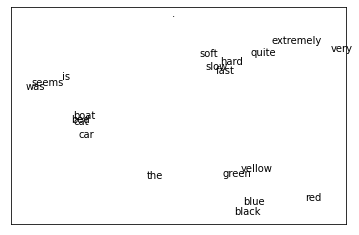

In [44]:
import matplotlib.pyplot as plt

# Extract the first two principal components and transform the word vectors
components = pca(embedding.embeddings, 2)
transformed = transform(embedding.embeddings, components)

# Scatter the points (and make them white so they are invisible)
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')

# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])

# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [45]:
# Recurrent Neural Network (RNN)
from scratch.deep_learning import tensor_apply, tanh

class SimpleRnn(Layer):
    """Just about the simplest possible recurrent layer."""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.w = random_tensor(hidden_dim, input_dim, init='xavier')
        self.u = random_tensor(hidden_dim, hidden_dim, init='xavier')
        self.b = random_tensor(hidden_dim)

        self.reset_hidden_state()

    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]

    def forward(self, input: Tensor) -> Tensor:
        self.input = input              # Save both input and previous
        self.prev_hidden = self.hidden  # hidden state to use in backprop.

        a = [(dot(self.w[h], input) +           # weights @ input
              dot(self.u[h], self.hidden) +     # weights @ hidden
              self.b[h])                        # bias
             for h in range(self.hidden_dim)]

        self.hidden = tensor_apply(tanh, a)  # Apply tanh activation
        return self.hidden                   # and return the result.

    def backward(self, gradient: Tensor):
        # Backpropagate through the tanh
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]

        # b has the same gradient as a
        self.b_grad = a_grad

        # Each w[h][i] is multiplied by input[i] and added to a[h],
        # so each w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]

        # Each u[h][h2] is multiplied by hidden[h2] and added to a[h],
        # so each u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]

        # Each input[i] is multiplied by every w[h][i] and added to a[h],
        # so each input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]

In [46]:
# Character-level RNN

from bs4 import BeautifulSoup
import requests

url = "https://www.ycombinator.com/topcompanies/"
soup = BeautifulSoup(requests.get(url).text, 'html5lib')

# We get the companies twice, so use a set comprehension to deduplicate.
companies = list({b.text # <b class="h4">Company</b>
                  for b in soup("b")
                  if "h4" in b.get("class", ())})

print(len(companies))

102


In [47]:
vocab = Vocabulary([c 
                    for company in companies 
                    for c in company])

START = "^" # regex character for start
STOP = "$"  # regex character for end

vocab.add(START)
vocab.add(STOP)

print(vocab.size)

55


In [48]:
HIDDEN_DIM = 32  # You should experiment with different sizes!
    
rnn1 =  SimpleRnn(input_dim=vocab.size, hidden_dim=HIDDEN_DIM)
rnn2 =  SimpleRnn(input_dim=HIDDEN_DIM, hidden_dim=HIDDEN_DIM)
linear = Linear(input_dim=HIDDEN_DIM, output_dim=vocab.size)

model = Sequential([
    rnn1,
    rnn2,
    linear
])

In [49]:
from scratch.deep_learning import softmax

def generate(seed: str = START, max_len: int = 50) -> str:
    rnn1.reset_hidden_state()  # Reset both hidden states.
    rnn2.reset_hidden_state()
    output = [seed]            # Start the output with the specified seed.

    # Keep going until we produce the STOP character or reach the max length
    while output[-1] != STOP and len(output) < max_len:
        # Use the last character as the input
        input = vocab.one_hot_encode(output[-1])

        # Generate scores using the model
        predicted = model.forward(input)

        # Convert them to probabilities and draw a random char_id
        probabilities = softmax(predicted)
        next_char_id = sample_from(probabilities)

        # Add the corresponding char to our output
        output.append(vocab.get_word(next_char_id))

    # Get rid of START and END characters and return the word.
    return ''.join(output[1:-1])

In [50]:
loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.9)

for epoch in range(300):
    random.shuffle(companies)  # Train in a different order each epoch.
    epoch_loss = 0             # Track the loss.
    for company in tqdm.tqdm(companies):
        rnn1.reset_hidden_state()  # Reset both hidden states.
        rnn2.reset_hidden_state()
        company = START + company + STOP   # Add START and STOP characters.

        # The rest is just our usual training loop, except that the inputs
        # and target are the one-hot-encoded previous and next characters.
        for prev, next in zip(company, company[1:]):
            input = vocab.one_hot_encode(prev)
            target = vocab.one_hot_encode(next)
            predicted = model.forward(input)
            epoch_loss += loss.loss(predicted, target)
            gradient = loss.gradient(predicted, target)
            model.backward(gradient)
            optimizer.step(model)

    # Each epoch print the loss and also generate a name
    print(epoch, epoch_loss, generate())

    # Turn down the learning rate for the last 100 epochs.
    # There's no principled reason for this, but it seems to work.
    if epoch == 200:
        optimizer.lr *= 0.1

  1%|▊                                                                              | 1/102 [00:00<00:11,  8.68it/s]

0 3422.363359013362 utteOEmbaaosat


  3%|██▎                                                                            | 3/102 [00:00<00:03, 25.48it/s]

1 3325.6529302835056 sruQSSicnoTbp baoSnrteob


  3%|██▎                                                                            | 3/102 [00:00<00:04, 23.97it/s]

2 3256.7251598361713 re


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.69it/s]

3 3192.989541996672 GeRlo


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.96it/s]

4 3141.5923399784456 aGevlaofiyocmrwmebcinsd ordeef


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.04it/s]

5 3106.312163508933 PXncenyc


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.54it/s]

6 3087.4230492385877 Prt


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

7 3059.110092714402 Geatptr


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.31it/s]

8 3036.754856718542 FMF Gtnecl


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.75it/s]

9 3014.061771553542 Rhediinseeifep


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.20it/s]

10 3006.9864211266513 Waztsy


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.57it/s]

11 2985.8585615696697 PeA.MG


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.64it/s]

12 2959.6625956735006 AxarSdlt


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.54it/s]

13 2944.1283709438826 LeM Fn


  3%|██▎                                                                            | 3/102 [00:00<00:05, 18.57it/s]

14 2929.266791730135 Slzod


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.28it/s]

15 2923.037465063761 Zobnpaamtnhxi


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.52it/s]

16 2902.9053007620882 Suee)


  1%|▊                                                                              | 1/102 [00:00<00:15,  6.43it/s]

17 2892.964945075839 Dionsk


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.45it/s]

18 2872.2368478314474 Guetoacu


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

19 2858.9440605741947 Gotawb


  1%|▊                                                                              | 1/102 [00:00<00:14,  7.11it/s]

20 2844.287878459344 Zaleo.e


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

21 2820.1232750358768 GorOsi


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.64it/s]

22 2802.0538936480175 CaBnrounSa xo


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.12it/s]

23 2788.7608593534987 Riafeq


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.28it/s]

24 2770.5681607770703 texk


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

25 2761.1702729433664 Wue)ya


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.81it/s]

26 2738.0931532988498 Miouaotga rdoss


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.38it/s]

27 2735.8792345776 PomTerkog


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.94it/s]

28 2723.858474630003 Gtoresle Ciuposy


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.23it/s]

29 2702.8354125591463 Ceontatisan


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.14it/s]

30 2693.6424970272437 Zeos


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.23it/s]

31 2677.8140801587915 W


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

32 2666.6146983129306 meMpgyknaR


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

33 2664.259798528957 Oohdalle Mcanuryr


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.04it/s]

34 2639.705379619851 Eiudtle


  3%|██▎                                                                            | 3/102 [00:00<00:03, 27.09it/s]

35 2622.9916648315493 Snseb ZyAwm


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.08it/s]

36 2616.3130305890154 Hofxihacg


  1%|▊                                                                              | 1/102 [00:00<00:14,  6.96it/s]

37 2597.6671099113064 Nigprt xir ISce


  3%|██▎                                                                            | 3/102 [00:00<00:03, 26.38it/s]

38 2580.421564529113 Cpatdeze


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.02it/s]

39 2576.2776135749295 Phexd


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

40 2561.7749533689366 Fautacd


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.12it/s]

41 2549.572971777191 mtleSDac Bhon


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.91it/s]

42 2540.9982187661544 Shsiy


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.44it/s]

43 2528.4048533530004 Atgerivelela Ceonti (nenuomt


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.12it/s]

44 2520.1937719131615 Grslal.


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.43it/s]

45 2486.866659567347 RieCBoy


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.22it/s]

46 2491.304133998794 Sacimntrcinn


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.31it/s]

47 2464.9252874530835 Gtottlasaz


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.59it/s]

48 2450.5509580404882 Catlatshg


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

49 2437.098398546883 TlapioX


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

50 2414.18537948389 DioGc


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.57it/s]

51 2399.3737502133627 Sipcalth


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

52 2401.936004078611 Bosd


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.08it/s]

53 2384.6670739230462 Slungharp


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.99it/s]

54 2373.3773944644845 GcOApuw


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.40it/s]

55 2343.360433178955 Corame


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.22it/s]

56 2321.577045060556 RemyBotisn


  3%|██▎                                                                            | 3/102 [00:00<00:06, 15.43it/s]

57 2315.2312879192305 SF


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.11it/s]

58 2296.924220334636 Pogp nb) Inc


  2%|█▌                                                                             | 2/102 [00:00<00:09, 10.84it/s]

59 2277.965624887 Fhunc


  1%|▊                                                                              | 1/102 [00:00<00:16,  6.19it/s]

60 2268.8482160189674 Pore


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.47it/s]

61 2253.625901561248 IurtO


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.77it/s]

62 2217.636421727898 Hatito


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

63 2210.179452866261 Smfloxth


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.69it/s]

64 2200.640143127007 Mevery


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.71it/s]

65 2171.170234271913 XoPtisD


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.57it/s]

66 2154.1994212381264 Sigybtare


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.92it/s]

67 2132.4790584433904 Meiare


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.83it/s]

68 2127.7222123831416 AFuxy


  3%|██▎                                                                            | 3/102 [00:00<00:04, 22.77it/s]

69 2109.4672169049413 Stuipo


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.29it/s]

70 2092.0551315844077 Fuipa


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.28it/s]

71 2080.0830898374793 Cuos


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

72 2065.3484968882303 Memfry Buger


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.19it/s]

73 2038.8601110736477 Gittt


  1%|▊                                                                              | 1/102 [00:00<00:11,  8.95it/s]

74 2022.4880159393697 Atrobteawo


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.30it/s]

75 2003.0644373896268 Fiopti


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.22it/s]

76 1977.6417621609269 FatPorome Inc


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.30it/s]

77 1977.282213781477 Mitpinel


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.02it/s]

78 1989.2686859124694 WeWiMoIn


  3%|██▎                                                                            | 3/102 [00:00<00:04, 24.06it/s]

79 1945.322246349541 T


  1%|▊                                                                              | 1/102 [00:00<00:11,  8.64it/s]

80 1912.8119591361212 Ritity


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.71it/s]

81 1902.4935653744749 Strirdaca


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.08it/s]

82 1900.1753476766057 Lergot


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.08it/s]

83 1855.5030739243252 Votlerzozt


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.64it/s]

84 1853.5841114310335 Shrie


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.32it/s]

85 1836.7267372543013 GorTOhacelit.


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.72it/s]

86 1837.75764764689 RafverI


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

87 1800.7988665269627 Nodca


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.02it/s]

88 1780.816817750543 Reushr


  3%|██▎                                                                            | 3/102 [00:00<00:04, 22.44it/s]

89 1787.5509163369309 Ftixcl


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.85it/s]

90 1752.722071683189 Snharkle IDee Shucaly.y Irel


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.30it/s]

91 1737.0099524844911 Grixbhve


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.01it/s]

92 1739.2906579998344 Paosi


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.97it/s]

93 1702.3956646109539 Notte


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

94 1748.6401453061308 MaterkOE


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.92it/s]

95 1714.12139674886 memeorSeSfarers


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.91it/s]

96 1698.4942285038592 EotiontSirelyon Coice


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.02it/s]

97 1697.0969759700215 VreXtard


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.62it/s]

98 1703.985720855577 Pamdy


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.57it/s]

99 1654.1637035581543 Welaleless SpOhepr


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.43it/s]

100 1635.8678823022915 Gut AquruSt


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.01it/s]

101 1633.978769697716 Ramqenw


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.55it/s]

102 1630.9773947322153 PledDaCasy,y)arg


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.28it/s]

103 1633.0680303950817 Surix


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.10it/s]

104 1622.9024026734287 Weepo )hunbSyd


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

105 1598.9074527795403 Blecyringv


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.78it/s]

106 1572.4986184119266 OlOPti CriniOpomium


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.33it/s]

107 1602.230888310071 Cocarpatel


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.99it/s]

108 1595.7791001247228 Flutterwa


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

109 1584.104309278736 Heesil


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.48it/s]

110 1573.395715090585 Atuire


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.41it/s]

111 1550.9482286461646 Thititi


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.28it/s]

112 1524.8942040545603 OOfnoxyd.aic


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.59it/s]

113 1487.5796183217742 Mew


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.59it/s]

114 1506.5220165235662 Fastab


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.61it/s]

115 1482.7485469830312 Lee


  1%|▊                                                                              | 1/102 [00:00<00:11,  9.12it/s]

116 1461.4606429117214 Maborime Eort Xuople


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.22it/s]

117 1485.61687833726 Giffrele Cicac


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.46it/s]

118 1472.8165959853932 Easerkument


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.28it/s]

119 1513.5858510779208 Relakguven


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.08it/s]

120 1447.5044574384124 Panqarditiues


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.02it/s]

121 1475.4526941468337 Raxorke


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.19it/s]

122 1469.5016041376562 Xeg


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.94it/s]

123 1500.749412725752 Plearkenv


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.85it/s]

124 1471.9475492602885 Zebfhont


  1%|▊                                                                              | 1/102 [00:00<00:18,  5.48it/s]

125 1491.091058494344 Se EB


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.08it/s]

126 1435.8950683332712 Mamery


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.30it/s]

127 1445.9900394618362 Zerolown


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.91it/s]

128 1443.4474110119957 Sintb


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.27it/s]

129 1444.172901606543 Rigerd


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.45it/s]

130 1400.5882580225511 NoserGuty,


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.02it/s]

131 1377.5752350886366 Sh X


  3%|██▎                                                                            | 3/102 [00:00<00:03, 24.85it/s]

132 1380.3656030192308 SeOle Inc


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.43it/s]

133 1359.7708292323991 Papwuonc


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.15it/s]

134 1339.6314987766561 Sift


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.27it/s]

135 1346.808434731276 DurbPipeaId


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.20it/s]

136 1394.7173415551335 Gmopbox


  3%|██▎                                                                            | 3/102 [00:00<00:03, 26.38it/s]

137 1402.4775475454053 PaneASenop duonsy.


  2%|█▌                                                                             | 2/102 [00:00<00:09, 10.39it/s]

138 1342.4766553565203 Gront


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.79it/s]

139 1327.9104647792258 Ridice


  3%|██▎                                                                            | 3/102 [00:00<00:04, 21.09it/s]

140 1437.715336384419 Rigo


  1%|▊                                                                              | 1/102 [00:00<00:14,  7.11it/s]

141 1402.729399976742 Atompast


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.04it/s]

142 1407.2614738866284 MePakont


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.32it/s]

143 1306.7642771609446 Were


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.04it/s]

144 1363.1380884467742 Heesas


  1%|▊                                                                              | 1/102 [00:00<00:12,  7.78it/s]

145 1369.6612639166601 Cloxozuurss


  1%|▊                                                                              | 1/102 [00:00<00:14,  6.87it/s]

146 1378.5104410617869 Curxd


  3%|██▎                                                                            | 3/102 [00:00<00:03, 27.60it/s]

147 1327.7604406291684 Prich


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.75it/s]

148 1288.8453906662883 Fruisenz


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.40it/s]

149 1329.49154412003 Eqite


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.78it/s]

150 1332.806410134819 Amplick, IncDng


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.59it/s]

151 1283.0425396181402 Amvele


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.32it/s]

152 1283.7563996508595 Rippoty


  1%|▊                                                                              | 1/102 [00:00<00:19,  5.22it/s]

153 1319.4972811269076 Emefto


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.82it/s]

154 1309.9641844394127 Stripsor


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.74it/s]

155 1383.238543206495 Fleorsaxation


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.20it/s]

156 1390.6615522576005 Mambac


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.36it/s]

157 1322.0466588668235 Wersonsarq


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.46it/s]

158 1279.796711866062 FrorABuom


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.91it/s]

159 1313.4857932555594 Eqittox


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.09it/s]

160 1259.5180161600597 Xeesl


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

161 1266.8325699618883 mipioliont


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.94it/s]

162 1237.8633271099095 Ripple


  1%|▊                                                                              | 1/102 [00:00<00:12,  7.83it/s]

163 1288.3917727218488 Nuppu


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

164 1285.6950967485188 Clearse. Sh


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

165 1246.6673940862247 Unbard


  3%|██▎                                                                            | 3/102 [00:00<00:04, 23.49it/s]

166 1242.6948156542594 Lob


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.85it/s]

167 1244.4569627157596 Vleybresto


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.05it/s]

168 1323.779434562536 WeamBows


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.14it/s]

169 1255.5042174996786 Axoni


  3%|██▎                                                                            | 3/102 [00:00<00:05, 18.05it/s]

170 1219.786748385679 Sdapaut


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

171 1264.384523722035 Auonty


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.08it/s]

172 1279.385957256854 Shinbabde Schvebo


  1%|▊                                                                              | 1/102 [00:00<00:11,  9.03it/s]

173 1251.0943542899101 Webli


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

174 1245.6689490248013 Scalazow


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.29it/s]

175 1195.6312603405297 Me T


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.99it/s]

176 1308.5900161937243 Insarea Sorielick


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.43it/s]

177 1274.9201339372937 Pegce


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

178 1252.9408043646526 ZermBob


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.06it/s]

179 1244.2518093107883 PlanGrid


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.32it/s]

180 1109.0215312494984 CenTgo


  3%|██▎                                                                            | 3/102 [00:00<00:04, 22.11it/s]

181 1231.7813348087823 Lasteris


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.93it/s]

182 1282.5229772536131 Pagetran


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.28it/s]

183 1278.4477138272828 Redamd


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.64it/s]

184 1298.8109068370907 GitPrimevigo Eute Tn


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.30it/s]

185 1215.1939206743853 HeabBix


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.22it/s]

186 1160.6754926012711 Panore


  1%|▊                                                                              | 1/102 [00:00<00:14,  7.01it/s]

187 1178.4368387583208 Flutterwaan Suit


  2%|█▌                                                                             | 2/102 [00:00<00:09, 10.66it/s]

188 1150.417747336142 Vtar


  1%|▊                                                                              | 1/102 [00:00<00:15,  6.39it/s]

189 1193.0785810007221 CroxyBige


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.11it/s]

190 1264.6163235210036 Burinednc


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.63it/s]

191 1189.643968965042 Sh Xrely


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.93it/s]

192 1170.414392832467 Redsa


  3%|██▎                                                                            | 3/102 [00:00<00:03, 25.71it/s]

193 1165.4424804851037 Prex


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.15it/s]

194 1166.956352558064 Civento


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.37it/s]

195 1166.178143961142 Nottis


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.28it/s]

196 1147.5319243272074 Pogn,ydicelaoD


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.53it/s]

197 1139.6962710886635 Guoxo


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.04it/s]

198 1104.3958461938098 Me Sgo


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.97it/s]

199 1134.5883826471947 Zadfran


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.79it/s]

200 1102.4043076338564 Fivetrbatruce Inc


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.46it/s]

201 1014.1550420368461 ShimBy


  3%|██▎                                                                            | 3/102 [00:00<00:04, 23.32it/s]

202 876.8998591663748 Nemikmenc


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.48it/s]

203 831.4344075898384 Fropbotid.


  3%|██▎                                                                            | 3/102 [00:00<00:04, 23.68it/s]

204 802.3895680819872 Crontitre Inc.


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.93it/s]

205 787.2272832512624 Aive


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

206 772.9946445594167 Proxic


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.93it/s]

207 764.6123304227101 Vuero Eort blad


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.64it/s]

208 753.5835229116198 Weab


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.90it/s]

209 748.4923438898238 Sifto


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.23it/s]

210 743.481375281437 Fidmi


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.20it/s]

211 740.0313135562295 Grin


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.28it/s]

212 737.0012927671823 Lemfli


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.11it/s]

213 737.610649517232 Mattarpap


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.17it/s]

214 733.3678862212198 NotablerIl


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.28it/s]

215 730.6341552415394 GoCardl


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

216 727.9247600116587 Fivetran


  3%|██▎                                                                            | 3/102 [00:00<00:03, 26.57it/s]

217 725.5271567420114 Qicktrogely, Inc


  1%|▊                                                                              | 1/102 [00:00<00:11,  8.94it/s]

218 722.6013157134205 Rapium


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.54it/s]

219 723.3640826348089 Hebflow


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.14it/s]

220 718.9055747490322 Remsqu


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

221 717.2141482460158 Latterport Cnc


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.66it/s]

222 714.0527545221221 PanoreBuoS


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.91it/s]

223 713.9579328232652 SFOfrimd


  3%|██▎                                                                            | 3/102 [00:00<00:04, 24.41it/s]

224 713.7203858333917 Bevasy


  3%|██▎                                                                            | 3/102 [00:00<00:05, 18.12it/s]

225 712.2632759816144 Aas


  3%|██▎                                                                            | 3/102 [00:00<00:05, 16.80it/s]

226 710.0644799823347 Helaitabax


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

227 710.3908262940483 Pedon


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.35it/s]

228 708.1688748728901 Fle st


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

229 710.664728923035 Razorzax


  3%|██▎                                                                            | 3/102 [00:00<00:05, 16.82it/s]

230 704.6140216397586 Fustely,tion


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.61it/s]

231 702.1663875929115 SendBird


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.40it/s]

232 701.5609046020464 GOAT


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.50it/s]

233 698.6114791885669 Twerz


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.14it/s]

234 700.607167319327 Matti


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.08it/s]

235 696.4106134050116 Leme


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.54it/s]

236 695.5166530193969 Scribmito


  2%|█▌                                                                             | 2/102 [00:00<00:08, 12.26it/s]

237 693.5788126354475 Heusird


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.23it/s]

238 694.1634958388187 Segment


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

239 694.4942769719817 PagerDumputing


  1%|▊                                                                              | 1/102 [00:00<00:17,  5.86it/s]

240 690.8996312405295 Flexport


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.37it/s]

241 690.2212358925008 Optimid


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.64it/s]

242 685.573649121428 Ateenir)acalin


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.63it/s]

243 685.8251508557514 Grin


  1%|▊                                                                              | 1/102 [00:00<00:12,  7.90it/s]

244 683.6270400813612 SFOX


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.86it/s]

245 683.1214338911828 Matterport


  3%|██▎                                                                            | 3/102 [00:00<00:04, 22.11it/s]

246 680.6911391100848 Nurinemeant


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.85it/s]

247 680.1660245148805 SFOX


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.67it/s]

248 679.6262457112462 Prowirg


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.46it/s]

249 678.3603221163208 Stripe


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.87it/s]

250 676.5145763206893 Dowprime


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

251 676.0577700776728 FloyGrid


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.97it/s]

252 676.4601510866238 Meedaz


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

253 675.2920083831492 BooThhire


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.83it/s]

254 673.9741494285582 Wegli


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.12it/s]

255 672.278761592946 Ginkgon


  3%|██▎                                                                            | 3/102 [00:00<00:04, 24.65it/s]

256 671.0528054603241 GinLn


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.79it/s]

257 671.976965270024 WendBawlic)


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.80it/s]

258 671.1366705589608 Corzkix


  1%|▊                                                                              | 1/102 [00:00<00:16,  6.27it/s]

259 669.336856521289 GitLab


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.71it/s]

260 668.3464398749666 HePay


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.99it/s]

261 669.7166785780461 Froxg


  2%|█▌                                                                             | 2/102 [00:00<00:07, 14.22it/s]

262 668.7301486482345 Foingaxwlazs


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.54it/s]

263 667.4825903571199 Benchling


  1%|▊                                                                              | 1/102 [00:00<00:11,  8.57it/s]

264 664.8175230194574 Esin


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.33it/s]

265 666.5125630917073 (atterDavuolless


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

266 665.6109707007726 Girkke


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.46it/s]

267 665.2518430564998 Twirm


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

268 664.6158138993909 Twitkrend


  3%|██▎                                                                            | 3/102 [00:00<00:04, 22.44it/s]

269 666.1816782776779 InfluxDux)


  2%|█▌                                                                             | 2/102 [00:00<00:07, 12.93it/s]

270 664.1477784800734 SOOX


  2%|█▌                                                                             | 2/102 [00:00<00:05, 19.86it/s]

271 661.1163913060473 Pogid


  4%|███                                                                            | 4/102 [00:00<00:04, 23.45it/s]

272 665.6699517705221 He I h


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.17it/s]

273 662.3986812327228 Gxoxle


  3%|██▎                                                                            | 3/102 [00:00<00:05, 19.53it/s]

274 660.1259026567521 He.lratige


  3%|██▎                                                                            | 3/102 [00:00<00:05, 17.80it/s]

275 661.5018714083799 Ehuipdix


  2%|█▌                                                                             | 2/102 [00:00<00:05, 16.85it/s]

276 659.148417179456 Ripplizdlac


  2%|█▌                                                                             | 2/102 [00:00<00:06, 16.57it/s]

277 659.5154263978957 Amplit


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.11it/s]

278 659.5084283815138 Laes


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

279 658.7424838212385 Atoon


  2%|█▌                                                                             | 2/102 [00:00<00:09, 10.18it/s]

280 656.2548078122685 Staplars


  1%|▊                                                                              | 1/102 [00:00<00:10,  9.64it/s]

281 658.1515065797705 Remdqi


  1%|▊                                                                              | 1/102 [00:00<00:12,  8.22it/s]

282 658.9687440225039 Rescql


  2%|█▌                                                                             | 2/102 [00:00<00:08, 11.86it/s]

283 659.2451652876991 Gusto


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.46it/s]

284 655.7056687293319 Airbntraic


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.73it/s]

285 658.987406076747 Welion Enerby


  1%|▊                                                                              | 1/102 [00:00<00:13,  7.62it/s]

286 658.1295702098305 Quero Educata Gce.ai


  2%|█▌                                                                             | 2/102 [00:00<00:06, 14.86it/s]

287 656.9990950891572 Ire m


  2%|█▌                                                                             | 2/102 [00:00<00:05, 17.75it/s]

288 659.0162071508246 Lostarpr, Inont


  3%|██▎                                                                            | 3/102 [00:00<00:03, 26.15it/s]

289 652.7952276178862 GitLab


  2%|█▌                                                                             | 2/102 [00:00<00:07, 13.37it/s]

290 654.6790384217561 Emupdo b


  3%|██▎                                                                            | 3/102 [00:00<00:04, 23.65it/s]

291 657.2659529294094 BenchlingSir


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.19it/s]

292 653.6282091842766 Grin


  3%|██▎                                                                            | 3/102 [00:00<00:03, 25.28it/s]

293 655.6615600696044 PlanGrid


  0%|                                                                                       | 0/102 [00:00<?, ?it/s]

294 653.0837272906713 le I nn.


  1%|▊                                                                              | 1/102 [00:00<00:11,  8.57it/s]

295 655.5063050525035 Rackerby


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.56it/s]

296 652.6486378807598 The Athletic


  2%|█▌                                                                             | 2/102 [00:00<00:06, 15.17it/s]

297 652.1660196496332 Mixpanel


  2%|█▌                                                                             | 2/102 [00:00<00:05, 18.40it/s]

298 652.6485913074545 Scalmesd


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [00:08<00:00, 11.93it/s]

299 650.8028940474424 Fivelolic
